In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
milk = pd.read_csv('monthly-milk-production.csv',index_col='Month')

In [3]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [4]:
milk.index = pd.to_datetime(milk.index)

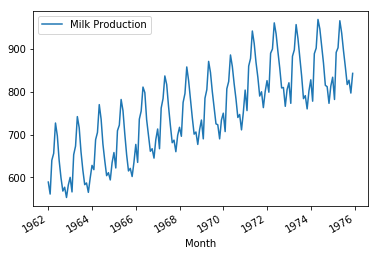

In [5]:
milk.plot()

In [6]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [7]:
train_set = milk.head(156)
test_set = milk.tail(12)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

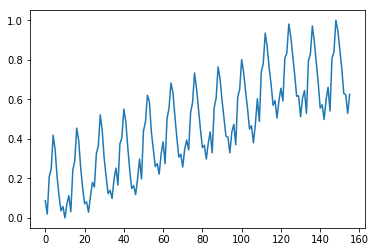

In [9]:
plt.plot(train_scaled)

In [10]:
def next_batch(training_data,batch_size,steps):
    rand_start = np.random.randint(0,len(training_data)-steps)
    
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    
    return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)

In [11]:
import tensorflow as tf

In [12]:
num_inputs = 1
num_time_steps = 12
num_neurons = 100
num_outputs = 1
learning_rate = 0.001
num_train_iterations = 6000
batch_size = 1

In [13]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [14]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=num_neurons,activation=tf.nn.relu)
    ,output_size=num_outputs)

In [15]:
output, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [16]:
loss = tf.reduce_mean(tf.square(output-y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [17]:
saver = tf.train.Saver()

In [18]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        
        sess.run(train,feed_dict={X:X_batch, y:y_batch})
        
        if iteration %100 == 0:
            
            mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
            print(iteration, "\tmse",mse)
            
    saver.save(sess, "./ex_time_series_model_code")

0 	mse 0.1710354
100 	mse 0.08820087
200 	mse 0.03717689
300 	mse 0.04008429
400 	mse 0.0174276
500 	mse 0.016435476
600 	mse 0.012742815
700 	mse 0.011768158
800 	mse 0.009111531
900 	mse 0.013146617
1000 	mse 0.0074585187
1100 	mse 0.009765991
1200 	mse 0.009436622
1300 	mse 0.007401766
1400 	mse 0.008981285
1500 	mse 0.006669977
1600 	mse 0.01023181
1700 	mse 0.0065862364
1800 	mse 0.008646543
1900 	mse 0.0070906966
2000 	mse 0.007892766
2100 	mse 0.0047900095
2200 	mse 0.009783362
2300 	mse 0.008749843
2400 	mse 0.009528513
2500 	mse 0.004614586
2600 	mse 0.0068461844
2700 	mse 0.0068230145
2800 	mse 0.007250967
2900 	mse 0.0045679626
3000 	mse 0.005637312
3100 	mse 0.007321445
3200 	mse 0.005609367
3300 	mse 0.007092904
3400 	mse 0.0041462705
3500 	mse 0.009337404
3600 	mse 0.008858131
3700 	mse 0.005033947
3800 	mse 0.005343873
3900 	mse 0.005614698
4000 	mse 0.0061457977
4100 	mse 0.0062213703
4200 	mse 0.003167664
4300 	mse 0.009062158
4400 	mse 0.0066534076
4500 	mse 0.0085084

In [19]:
with tf.Session() as sess:
    saver.restore(sess, "ex_time_series_model_code")
    
    train_seed = list(train_scaled[-12:])
    
    for iteration in range(12):
        
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(output, feed_dict = {X:X_batch})
        
        train_seed.append(y_pred[0,-1,0])
        

INFO:tensorflow:Restoring parameters from ex_time_series_model_code


In [20]:
train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.6569506,
 0.6602885,
 0.7959987,
 0.9136442,
 1.027735,
 0.98488665,
 0.8339112,
 0.7111594,
 0.5923957,
 0.5457297,
 0.53699064,
 0.5823918]

In [21]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

In [22]:
test_set['Generated'] = results

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
test_set

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,826.291443
1975-02-01 01:00:00,782.0,827.680054
1975-03-01 01:00:00,892.0,884.135498
1975-04-01 01:00:00,903.0,933.075989
1975-05-01 01:00:00,966.0,980.537720
1975-06-01 01:00:00,937.0,962.712830
1975-07-01 01:00:00,896.0,899.907043
1975-08-01 01:00:00,858.0,848.842285
1975-09-01 01:00:00,817.0,799.436646


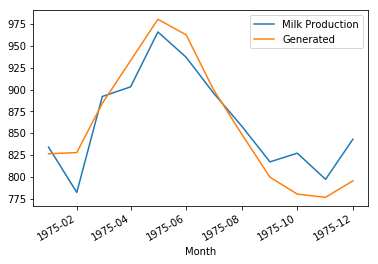

In [24]:
test_set.plot()